# Heatmaps - 2D and 3D
This notebook demonstrates the importance of heatmap (heightmap) in data visualization and how to implement it in Python.

## Introduction
Heatmaps are a visualization tool in machine learning, commonly used to indicate the difference and similarity between sample groups. A 2D heatmap is represented in a matrix where each cell contains a value. The cells are colored corresponding to their data, and the color intensity usually describes the value magnitude. 3D heatmaps are also called heightmaps in some circumstances, for example, in a GIS system, the temperature distribution represented by a heatmap can be converted into a heightmap to show the temperature variation in a more intuitive way.

## Implementation
Let's implement heatmap(2D) using the popular python libraries `numpy` and `matplotlib`.

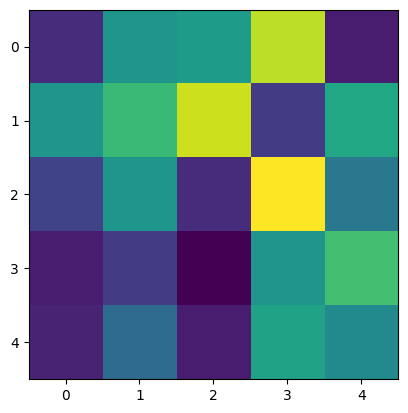

In [40]:
import numpy as np
import matplotlib.pyplot as plt
fruit = ["apple", "cherry", "banana", "pear", "coconut"]     
city = ["Beijing", "Shanghai", "Guangzhou", "Shenzhen", "Chongqing"]

price = np.array([[0.8, 2.4, 2.5, 3.9, 0.6],
                    [2.4, 3.0, 4.0, 1.0, 2.7],
                    [1.1, 2.4, 0.8, 4.3, 1.9],
                    [0.6, 1.0, 0.3, 2.4, 3.1],
                    [0.7, 1.7, 0.6, 2.6, 2.2]])

fig, ax = plt.subplots()  
im = ax.imshow(price)   

Here's a more complex example, a 2D heatmap is created with three Guassian functions. Value of the heatmap at each point (x, y) are calculated as the weighted sum of these Guassian functions. The original code can be found at [Heightmap](https://github.com/41pha1/Heightmap2STL).

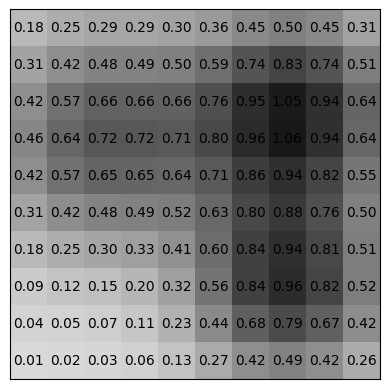

In [28]:
import math
from itertools import product
txcolor = 'black'
# guassian function centers and spreads
x1, y1 = 2, 3
x2, y2 = 7, 7
x3, y3 = 7.2, 2.3
s1, s2, s3 = 2.2, 1.8, 1.9
# create the heightmap with three guassian functions
gauss1 = lambda x, y: math.exp(-0.5 * (((x - x1) / s1) ** 2 + ((y - y1) / s1) ** 2))
gauss2 = lambda x, y: math.exp(-0.5 * (((x - x2) / s2) ** 2 + ((y - y2) / s2) ** 2))
gauss3 = lambda x, y: math.exp(-0.5 * (((x - x3) / s3) ** 2 + ((y - y3) / s3) ** 2))
heightmap = [[0.7 * gauss1(x, y) + 0.9 * gauss2(x, y) +  gauss3(x, y) for x in range(10)] for y in range(10)]

plt.imshow(heightmap, cmap='binary', vmax=1.2, vmin=-0.2)
for i, j in product(range(10), range(10)):
    plt.text(j, i, '%.2f' % heightmap[i][j], color=txcolor, va='center', ha='center')
    pass
plt.xticks([])
plt.yticks([])
plt.show()

2D heatmaps generated above can be converted into STL files through the code below. An STL(StereoLithography) file shows a three-dimensional figure. Its surface is subdivided into a series of small triangles. Tools like 3D Viewer can open an STL file. The conversion from 2D heatmap input file to a 3D output file: 

![heightmap](../examples/Heatmap.png)

In [29]:
import os
import sys
import cv2 as cv
import trimesh as tm

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

class QuadTreeNode:
    def __init__(self, x, y, width, height, depth):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.depth = depth

    def corners(self):
        return [
            (self.x, self.y),
            (self.x + self.width, self.y),
            (self.x, self.y + self.height),
            (self.x + self.width, self.y + self.height),
        ]

def detail_magnitude(heightmap):
    """Calculate the detail magnitude of a heightmap.
    heightmap: a 2d array of floats between 0 and 1.
    returns: a 2d array of floats between 0 and 1.
    """

    blured = cv.GaussianBlur(heightmap,(11,11),0) * 255

    gX = cv.Sobel(blured, ddepth=cv.CV_64F, dx=1, dy=0, ksize=5)
    gY = cv.Sobel(blured, ddepth=cv.CV_64F, dx=0, dy=1, ksize=5)

    gX = cv.convertScaleAbs(gX)
    gY = cv.convertScaleAbs(gY)

    return cv.addWeighted(gX, 0.5, gY, 0.5, 0)

def triangulate(vertices, poly):
    """Triangulate a polygon.
    poly: a list of indices of vertices in clockwise order.
    returns: a list of triangle indices.
    """
    
    #place an additional vertex in the center of the polygon.
    points = [vertices[i] for i in poly]
    center = (sum([p[0] for p in points]) // len(points), sum([p[1] for p in points]) // len(points))
    center_index = len(vertices)
    vertices.append(center)
    # Triangulate the polygon.
    triangles = []

    for i in range(len(poly)):
        triangles.append([poly[i], center_index, poly[(i+1) % len(poly)]])

    return triangles

def createFaces(vertices, polys):
    """Triangulate a list of polygons.
    vertices: a list of vertices.
    polys: a list of list containing the indices of the vertices of each polygon.
    returns: a list of triangle indices.
    """

    triangles = []

    for poly in polys:
        triangles += triangulate(vertices, poly)

    return triangles

def getSourroundingVertices(vert_set, x, y, w, h):
    """Find all vertices in a rectangle.
    vertices: a dictionary of vertices.
    x, y, w, h: the rectangle to search (integers).
    returns: a list of indices of the vertices in the rectangle.
    """

    north, east, south, west = [], [], [], []

    for i in range(x, x + w):
        point = (i, y)

        if point in vert_set:
            north.append(vert_set[point])

    for i in range(y, y + h):
        point = (x + w, i)

        if point in vert_set:
            east.append(vert_set[point])

    for i in range(x + w, x, -1):
        point = (i, y + h)

        if point in vert_set:
            south.append(vert_set[point])

    for i in range(y + h, y, -1):
        point = (x, i)

        if point in vert_set:
            west.append(vert_set[point])

    return north, east, south, west

def createPolyFaces(vert_set, leafs):
    """Find all sourrounding vertices of a leaf and create a polygonal face from them.
    vert_set: a dictionary of vertices.
    leafs: a list of QuadTreeNodes.
    returns: a list of list containing the indices of the vertices of each face.
    """

    # TODO: This function is very slow. Optimize it by sorting the vertices and using a binary search to find them.

    polys = []

    for leaf in leafs:
        n,e,s,w = getSourroundingVertices(vert_set, leaf.x, leaf.y, leaf.width, leaf.height)
        polys.append(n+e+s+w)

    return polys


def subdivideAdaptive(detail_map, max_subdivisions, threshold):
    """Subdivide a plane based on the detail map.
    detail_map: a 2d array of floats between 0 and 1.
    max_subdivisions: the maximum number of times to subdivide the plane.
    threshold: the minimum detail value to subdivide the plane at.
    """

    # Make the detail map square and a power of 2.
    n = 2 ** max_subdivisions
    threshold *= n * n

    #Create an accumulated sum of the detail map.
    acc_sum = np.cumsum(detail_map, axis=0)
    acc_sum = np.cumsum(acc_sum, axis=1)
    acc_sum = np.swapaxes(acc_sum, 0, 1)

    # Create a list of nodes to subdivide.
    plane = [QuadTreeNode(0, 0, n, n, 0)]
    leafs = []
    vert_set = {}

    # Subdivide the plane until we reach the maximum resolution.

    print("Subdividing plane {} times...".format(max_subdivisions))
    for i in range(max_subdivisions):
        
        # Subdivide the plane.
        new_plane = []
        for node in plane:
            # Calculate the detail of the node.
            detail = acc_sum[node.x + node.width - 1, node.y + node.height - 1] + acc_sum[node.x, node.y] - acc_sum[node.x, node.y + node.height - 1] - acc_sum[node.x + node.width - 1, node.y]

            # If the detail is greater than the threshold, subdivide the node.
            if detail > threshold:
                new_plane.append(QuadTreeNode(node.x, node.y, node.width // 2, node.height // 2, node.depth + 1))
                new_plane.append(QuadTreeNode(node.x + node.width // 2, node.y, node.width // 2, node.height // 2, node.depth + 1))
                new_plane.append(QuadTreeNode(node.x, node.y + node.height // 2, node.width // 2, node.height // 2, node.depth + 1))
                new_plane.append(QuadTreeNode(node.x + node.width // 2, node.y + node.height // 2, node.width // 2, node.height // 2, node.depth + 1))
            
            # Otherwise, add the node to the leafs and add its corners to the vertices.
            else:
                for corner in node.corners():
                    if not corner in vert_set:
                        vert_set[corner] = len(vert_set)

                leafs.append(node)

        # Replace the old plane with the new plane.
        plane = new_plane

    leafs += plane

    print("Creating polygonal faces from {} nodes...".format(len(vert_set)))
    polys = createPolyFaces(vert_set, leafs)
    
    vertices = [None] * len(vert_set)
    for key in vert_set:
        vertices[vert_set[key]] = key

    print("Triangulating {} polygons...".format(len(polys)))
    triangles = createFaces(vertices, polys)

    print("Done.")
    return vertices, triangles, getSourroundingVertices(vert_set, 0, 0, n, n)

def createTerrain(heightmap, max_subdivisions, threshold, z_scale, ground_height):
    """Create a terrain volume from a heightmap.
    heightmap: a 2d array of floats between 0 and 1.
    max_subdivisions: the maximum number of times to subdivide the plane.
    threshold: the minimum detail value to subdivide the plane at.
    z_scale: the height of the terrain.
    ground_height: the thickness of the ground.
    """

    # Validate the inputs.
    assert max_subdivisions > 0
    assert threshold >= 0

    n = 2 ** max_subdivisions
    aspect = heightmap.shape[1] / heightmap.shape[0]
    heightmap = cv.resize(heightmap, (n + 1, n + 1), interpolation=cv.INTER_CUBIC)

    detail = detail_magnitude(heightmap)
    vertices, triangles, (north, east, south, west) = subdivideAdaptive(detail, max_subdivisions, threshold)

    # Adjust the vertices to the correct height.
    print("Adjusting vertices...")
    for i in range(len(vertices)):
        vertices[i] = [vertices[i][1] / n, aspect * vertices[i][0] / n, heightmap[vertices[i][1], vertices[i][0]] * z_scale]
    
    # Create the sides of the terrain.
    sides = [north + east[:1], east + south[:1], south + west[:1], west + north[:1]]
    edge = []
    for side in sides:
        for i in range(len(side)):
            vertex = vertices[side[i]].copy()
            vertex[2] = ground_height
            vertices.append(vertex)
            edge.append(len(vertices) - 1)

            if i > 0:
                triangles.append([side[i], len(vertices)-1, side[i-1]])
                triangles.append([len(vertices) - 2, side[i-1], len(vertices)-1])

    # Create the bottom of the terrain.
    vertex = [0.5, 0.5 * aspect, ground_height]
    vertices.append(vertex)

    for i in range(len(edge)):
        triangles.append([edge[i], edge[(i+1) % len(edge)], len(vertices) - 1])

    print("Exporting to stl file...")
    return tm.Trimesh(vertices=np.array(vertices), faces=np.array(triangles))

def parseArgs(args):
    """Parse the command line arguments."""
    nx = 1
    ny = 1
    max_subdivisions = 10
    threshold = 0.01
    z_scale = 1
    ground_height = 0
    input_file = args[0]
    output_file = os.path.splitext(input_file)[0]

    return nx, ny, max_subdivisions, threshold, z_scale, ground_height, input_file, output_file

def main():
    nx, ny, max_subdivisions, threshold, z_scale, ground_height, input_file, output_file = parseArgs(sys.argv[1:])
    output_dir = os.path.splitext(output_file)[0]

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Reading heightmap...")
    x1, y1 = 2, 3
    x2, y2 = 7, 7
    x3, y3 = 7.2, 2.3
    s1, s2, s3 = 2.2, 1.8, 1.9
    gauss1 = lambda x, y: math.exp(-0.5 * (((x - x1) / s1) ** 2 + ((y - y1) / s1) ** 2))
    gauss2 = lambda x, y: math.exp(-0.5 * (((x - x2) / s2) ** 2 + ((y - y2) / s2) ** 2))
    gauss3 = lambda x, y: math.exp(-0.5 * (((x - x3) / s3) ** 2 + ((y - y3) / s3) ** 2))
    heightmap = [[0.7 * gauss1(x, y) + 0.9 * gauss2(x, y) +  gauss3(x, y) for x in range(10)] for y in range(10)]
    heightmap = np.array(heightmap) / np.max(heightmap) * 1.2
    
    w = heightmap.shape[1] // nx
    h = heightmap.shape[0] // ny

    for i in range(nx):
        for j in range(ny):
            print("Creating terrain for ({}, {})...".format(i, j))
            heightmap_section = heightmap[j*h:(j+1)*h, i*w:(i+1)*w]
            terrain_mesh = createTerrain(heightmap_section, max_subdivisions, threshold, z_scale, ground_height)
            terrain_mesh.export(os.path.join('../examples/heatmap_3d.stl'))
            
if __name__ == "__main__":
    main()

Reading heightmap...
Creating terrain for (0, 0)...
Subdividing plane 10 times...
Creating polygonal faces from 8098 nodes...
Triangulating 7666 polygons...
Done.
Adjusting vertices...
Exporting to stl file...


## Best Practices
- When drawing a heatmap, make sure to choose the colors carefully. It will directly affect the readability of the map. Pick color combinations that have a strong contrast and not easily misread by others.
- Data normalization makes heat maps easier to interpret, especially when the range of data values varies widely.
- Tags and notations can help readers better understand what the heatmap is about, add them if necessary.